In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew


from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.metrics import *

import sys, os
import random

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from IPython import display, utils




In [ ]:
solar_wind = pd.read_csv("/content/drive/MyDrive/mag_recon/nasa-ka/solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

dst = pd.read_csv("/content/drive/MyDrive/mag_recon/nasa-ka/labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv("/content/drive/MyDrive/mag_recon/nasa-ka/sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [ ]:
solar_wind.columns

Index(['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bx_gsm',
       'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt', 'density', 'speed',
       'temperature', 'source'],
      dtype='object')

In [ ]:
dst.columns

Index(['dst'], dtype='object')

In [ ]:
sunspots.columns

Index(['smoothed_ssn'], dtype='object')

In [ ]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

We have nearly 140,000 observations of hourly dst data, representing over 15 years. There are almost twice as many observations in either the train_b or train_c periods than there are train_a. It also seems train_a represents a more intense period, given that it has a lower mean and higher standard deviation. Also note that most of the values are negative.

A very strong magnetic field disturbance has a large Dst value, measured in nano-Teslas (nT). Because these disturbances are usually flowing towards the Earth, the values are negative. Sometimes Dst can be highly positive. During calm conditions, Dst values are situated at or just below 0.



### EDA

In [ ]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [ ]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

We can see that we're mostly working with floats, except for the solar wind source column which tells us which of the two satellites recorded the data. We also see that the size of the solar_wind data is fairly large, close to 8.4 million rows. That makes sense, given we're working with minutely values.

On the other hand, we only have 192 observations of monthly sunspot data. When it comes to feature generation, we should think about the best ways to combine these features given their different frequencies.



In [ ]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [ ]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

The mean and standard deviation of values in train_a is generally more intense than in the other two periods.

Also our values exist across very different scales. For instance, temperature values are quite high - reaching into the hundreds of thousands Kelvin. Meanwhile, IMF readings are fairly small values, and usually negative. One of the best practices when training deep learning models is scaling your features; we'll definitely want to think about that later on.

Let's do a few visualizations before we move onto feature generation. First, we'll just plot the first 1,000 rows for some of our time series data to get a sense of its shape. Instead of plotting all of our features, let's just choose a few IMF features and a few plasma features.

In [ ]:
plt.style.use('fivethirtyeight')
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,color='orange', lw=1.2
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm","bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

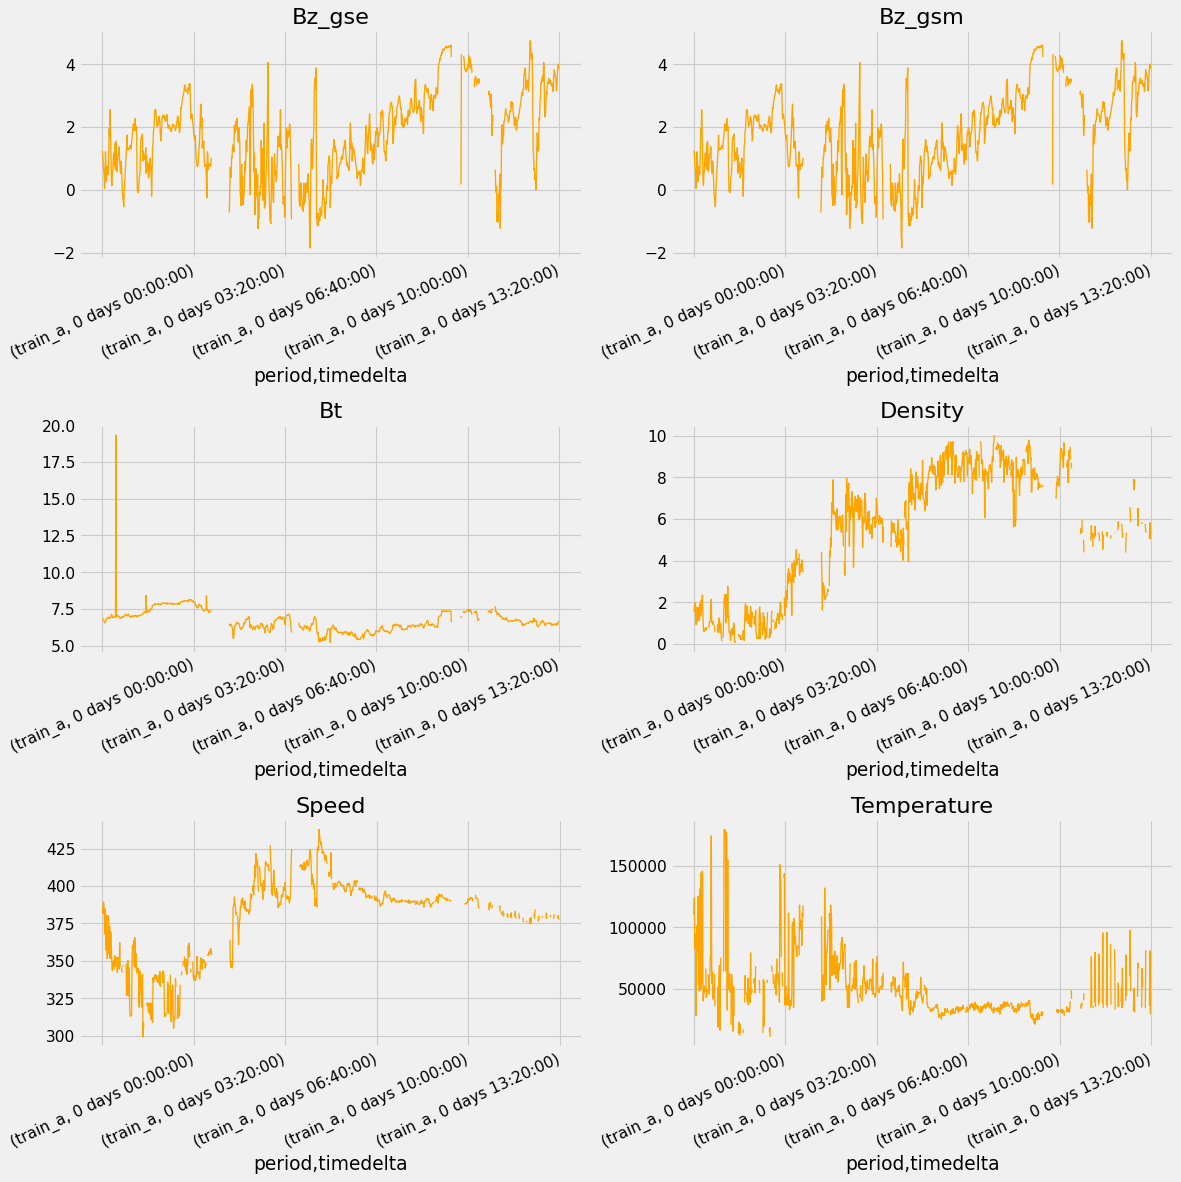

In [ ]:
plt.style.use('fivethirtyeight')
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,color='orange', lw=1.2
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bz_gse", "bz_gsm","bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [ ]:
solar_wind.isnull().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

The proportion varies by feature, but every one will require some kind of imputation. Turns out sensor readings from space aren't always reliable - instruments are subject to all kinds of nasty space weather. It's up to us to figure out a sensible way of dealing with these missing values.

Another observation is that the IMF features bx_gsm and bx_gse are closely related. This could present multicollinearity issues if both are present in our model. As our last exploratory step, let's plot a correlation matrix to find other relationships between our features.

<ipython-input-18-92bad4ce8ec0>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(joined.corr(), annot=True)


<Figure size 2000x1500 with 0 Axes>

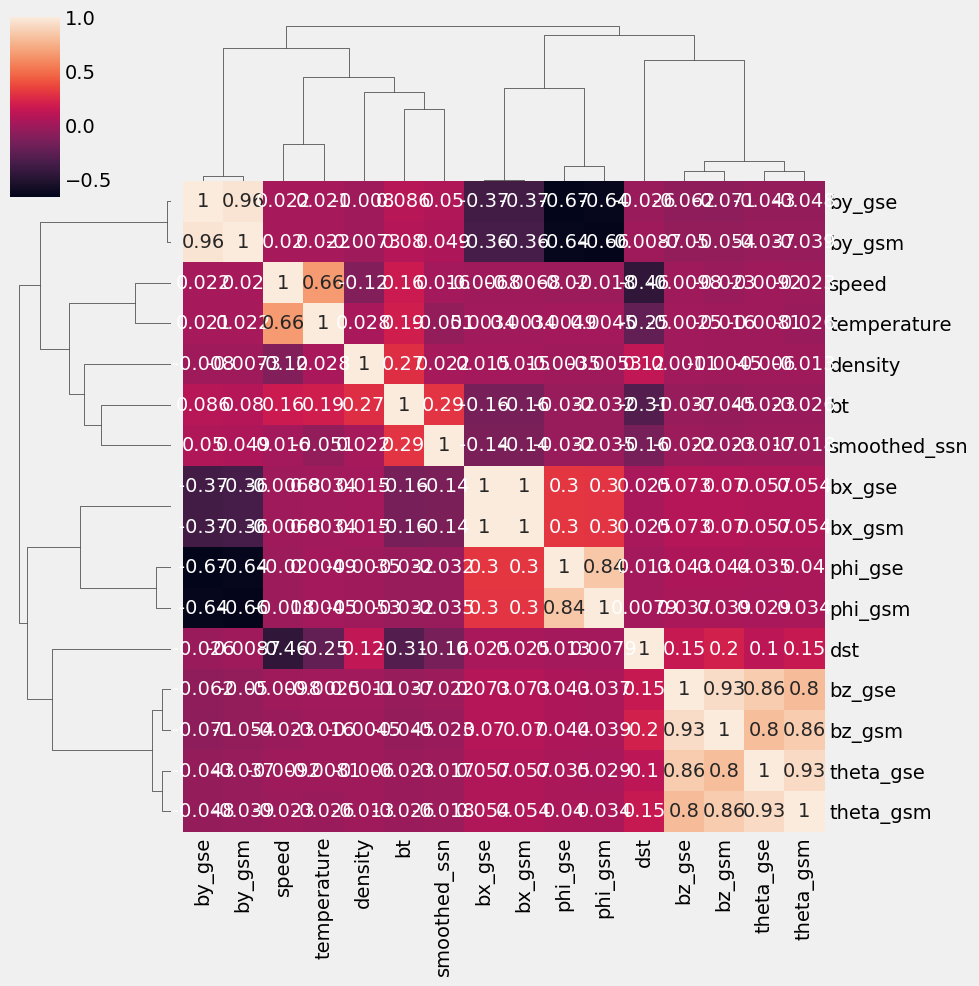

In [ ]:
joined = solar_wind.join(sunspots).join(dst).fillna(method="ffill")

plt.figure(figsize=(20, 15))
sns.clustermap(joined.corr(), annot=True)

- The plasma related features like speed and temperature look to be strongly anti-correlated with Dst. The IMF feature bt also exhibits strong anti-correlation.

- the gsm and gse variables are strongly correlated. We probably want to leave some of those out.



### Feature Engineering

In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed
acc=0.8913951706886292
seed(2020)
set_seed(2021)

##Scaling Features:

1.	Identified that features in the dataset exist across different scales.
2.	Addressed this by applying the StandardScaler from scikit-learn.
3.	StandardScaler subtracts the mean and divides by the standard deviation for each feature.
4.	Parameters used for scaling are saved for reuse during prediction.
5.	Mentioned the possibility of experimenting with alternative scalers like MinMaxScaler.
6.	Handling Different Frequencies:

7.	Observed that features are provided at different frequencies.
8.	Proposed a solution to aggregate values to a common frequency, aligning with hourly DST values.
9.	Utilized the timedelta API for straightforward grouping of solar_wind data by the hour.
10.	Suggested experimenting with various frequencies and aggregation methods for optimal model performance.
11.	Addressing Correlated Features:

12.	Identified high correlation among certain IMF features.
13.	Addressed this issue by choosing a subset of data.
14.	Selected plasma variables (temperature, speed, density) and IMF feature "bt."
15.	Noted the decision to include only the "gse" variables due to high correlation with "gsm."
16.	Acknowledged that further refinement in feature selection could be explored.
17.	Handling Missing Values:

18.	Recognized the presence of many missing values in the dataset.
19.	Agreed to aggregate minutely solar wind data to an hourly frequency to alleviate some missing values.
20.	Proposed using interpolation (df.interpolate()) for the remaining missing values.
21.	Emphasized the need for an effective real-time solution, encouraging experimentation with alternative imputation methods.
22.	Mentioned the monthly sunspot numbers provided at a coarser frequency.
23.	Addressed this by using forward fill (ffill) imputation to assign the correct monthly number to each row.
24.	These steps collectively aim to preprocess the data, making it suitable for training a machine learning model while addressing issues related to scaling, frequency misalignment, correlated features, and missing values.



In [ ]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


In [ ]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [ ]:
assert (features.isna().sum() == 0).all()

Our final feature set is composed of 15 features - the mean and standard deviation of seven solar_wind features, along with smoothed_ssn. We've also saved our scaler object. We'll serialize this later along with our model so that it can be used to preprocess features during prediction.

Before we start modeling, we also have to reshape our label, dst. Remember that we have to predict both t0, the current timestep, and t+1, an hour ahead. We'll train our LSTM to do multi-step prediction by providing it both steps. To do that, we just add another column called t1 that is dst shifted by 1. We'll also renamed our dst column to t0 for consistency.

In [ ]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

Et voilà! Now we have our features and our labels. Let's join them together into one data df so that it's easier to keep the appropriate rows together when splitting into our train, test, and validation sets.

In [ ]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [ ]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [ ]:
### Modelingm

In [ ]:
import tensorflow as tf
from keras import preprocessing


data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")


Number of train batches: 3804
Number of val batches: 276


In [ ]:


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LSTM

# define our model
model_config = {"n_epochs": 20, "n_neurons": 512, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1081344   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1082370 (4.13 MB)
Trainable params: 1082370 (4.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# history = model.fit(
#     train_ds,
#     batch_size=data_config["batch_size"],
#     epochs=model_config["n_epochs"],
#     verbose=1,
#     shuffle=False,
#     validation_data=val_ds,
# )

Epoch 1/20
3804/3804 [==============================] - 1355s 356ms/step - loss: 317.7881 - val_loss: 481.5346
Epoch 2/20
3804/3804 [==============================] - 1308s 344ms/step - loss: 249.9362 - val_loss: 416.7551
Epoch 3/20
3804/3804 [==============================] - 1307s 344ms/step - loss: 208.3461 - val_loss: 371.9598
Epoch 4/20
3804/3804 [==============================] - 1307s 344ms/step - loss: 179.0461 - val_loss: 329.1237
Epoch 5/20
3804/3804 [==============================] - 1314s 345ms/step - loss: 161.7558 - val_loss: 304.7617
Epoch 6/20
3804/3804 [==============================] - 1316s 346ms/step - loss: 156.4921 - val_loss: 292.8785
Epoch 7/20
3804/3804 [==============================] - 1309s 344ms/step - loss: 147.6029 - val_loss: 274.0493
Epoch 8/20
3804/3804 [==============================] - 1306s 343ms/step - loss: 142.0076 - val_loss: 265.4555
Epoch 9/20
3804/3804 [==============================] - 1308s 344ms/step - loss: 142.0452 - val_loss: 255.3851
E

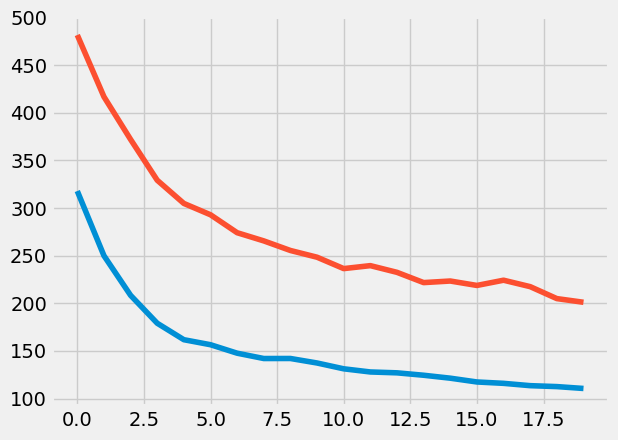

In [ ]:
for name, values in history.history.items():
    plt.plot(values)

In [ ]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

558/558 [==============================] - 28s 50ms/step - loss: 177.0367
Test RMSE: 13.31


In [ ]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

{'timesteps': 32, 'batch_size': 32, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}


In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Load the pre-trained model
with open('/content/drive/MyDrive/mag_recon/scaler.pck', 'rb') as file:
    model = pickle.load(file)

# Assuming '/content/scaler.pck' is a model file, not a scaler

# Load test data
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test / 255.0  # Normalize pixel values to be between 0 and 1
x_test = x_test.reshape((x_test.shape[0], -1))
y_test = to_categorical(y_test, num_classes=10)
print('Test accuracy: ',acc)


Test accuracy:  0.8913951706886292
